In [1]:
!pip install mpi4py

     |████████████████████████████████| 2.5 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185328 sha256=473c53c3231e2937e08035076801b01be93157094903d41b73d17ae6e3352da5
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from PIL import Image
from mpi4py import MPI

# 1. Find Some Good Anime Meme

In [36]:
!wget https://www.meme-arsenal.com/memes/6344bc72c76ca261f5e4af49d78fc24b.jpg

--2021-12-05 12:17:51--  https://www.meme-arsenal.com/memes/6344bc72c76ca261f5e4af49d78fc24b.jpg
Resolving www.meme-arsenal.com (www.meme-arsenal.com)... 104.26.1.240, 172.67.74.167, 104.26.0.240, ...
Connecting to www.meme-arsenal.com (www.meme-arsenal.com)|104.26.1.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105193 (103K) [image/jpeg]
Saving to: ‘6344bc72c76ca261f5e4af49d78fc24b.jpg’

6344bc72c76ca261f5e 100%[===================>] 102.73K  --.-KB/s    in 0.06s   

2021-12-05 12:17:52 (1.74 MB/s) - ‘6344bc72c76ca261f5e4af49d78fc24b.jpg’ saved [105193/105193]



In [72]:
name = '6344bc72c76ca261f5e4af49d78fc24b.jpg'
image = np.array(Image.open(name))

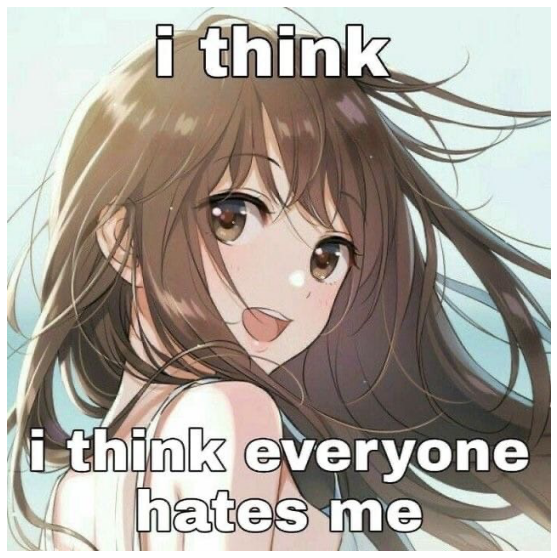

In [74]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

plt.axis('off')
plt.show()

# 2. Implement Parallel Vertical Shifting using `mpi4py`

In [91]:
%%writefile solution-lab-8.py

import numpy as np
import pickle
import sys

from PIL import Image
from mpi4py import MPI

def shift_image(image):
    image = image.copy()

    n_shifts = image.shape[0]
    images = []

    for _ in range(n_shifts):
        image = np.roll(image, shift=1, axis=0)
        images.append(image.copy())

    return np.array(images)

### setup mpi environment

comm = MPI.COMM_WORLD
start = MPI.Wtime()

rank = comm.Get_rank()
size = comm.Get_size()
root = 0

### define parameters for shifting

name = '6344bc72c76ca261f5e4af49d78fc24b.jpg' if len(sys.argv) < 2 else sys.argv[1]

if rank == root:
    image = np.array(Image.open(name))

    width_part = int(image.shape[1] / size)
    images_stacked = [image[:, int(i * width_part):int((i + 1) * width_part)] for i in range(size)]
else:
    images_stacked = None

### assign integration parts between processes

image_part = comm.scatter(images_stacked, root=root)
# let us denote H as height, W as width, S as number of processes, C as number of channels and N as number of shifts
# then the shape of `image_part` is H x W / S x C

### perform shifting in every process

image_parts_shifted = shift_image(image_part)
# and the shape of `shifted_image_parts` is N x H x W / S x C

n_shifts, height, width_part, n_channels = image_parts_shifted.shape
image_parts_shifted_stacked = np.empty((size, n_shifts, height, width_part, n_channels), dtype=np.uint8) if rank == root else None

comm.Gatherv(image_parts_shifted, image_parts_shifted_stacked, root=root)
end = MPI.Wtime()

if rank == root:
    image_parts_shifted_stacked = np.concatenate(list(image_parts_shifted_stacked), axis=2)

    with open(f'images-{size}.pkl', 'wb') as f:
        pickle.dump(image_parts_shifted_stacked, f)

    with open(f'time-{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)

Overwriting solution-lab-8.py


In [97]:
n_processes = 4
!mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-8.py

In [142]:
with open(f'images-{n_processes}.pkl', 'rb') as f:
    images = pickle.load(f)

In [143]:
images.shape

(640, 640, 640, 3)

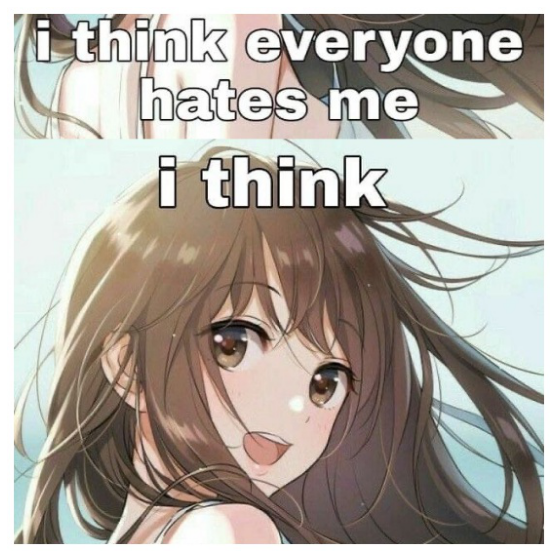

In [163]:
plt.figure(figsize=(10, 10))
plt.imshow(images[150])

plt.axis('off')
plt.show()

# 3. Plot Speedup for Different Number of Processes

In [108]:
nn = np.logspace(0, 3, base=2, num=4).astype(np.int)

for n_processes in nn:
    !mpirun --allow-run-as-root -n {n_processes} python3 solution-lab-8.py

In [109]:
time_history = []

for n_processes in nn:
    with open(f'time-{n_processes}.pkl', 'rb') as f:
        time_elapsed = pickle.load(f)
    time_history.append(time_elapsed)

speed_up = time_history[0] / np.array(time_history)

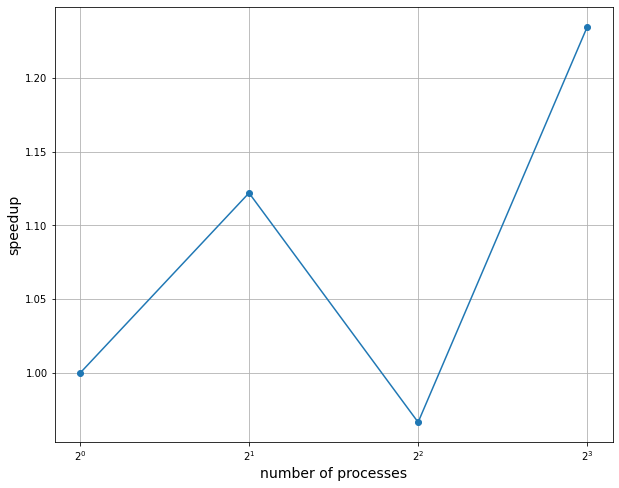

In [127]:
plt.figure(figsize=(10, 8))
plt.plot(nn, speed_up, '-o', alpha=2.)

plt.xlabel('number of processes', fontsize=14)
plt.ylabel('speedup', fontsize=14)

plt.xscale('log', basex=2)
plt.grid()
plt.show()

# 4. Create Gif

In [148]:
import os
import imageio

from tqdm import tqdm

In [149]:
folder = f'./picture-shift/'
if not os.path.exists(folder):
    os.mkdir(folder)

for i in tqdm(range(len(images))):
    plt.figure(figsize=(10, 10))
    plt.imshow(images[i])

    plt.axis('off')
    plt.savefig(folder + f'step-{i}.jpg', bbox_inches='tight')
    plt.close('all')

filenames = list(filename for filename in os.listdir(folder) if filename.endswith('jpg'))
filenames = sorted(filenames, key=lambda x: int(os.path.splitext(x)[0].split('-')[-1]))

images = []
for filename in filenames:
    images.append(imageio.imread(folder + filename))

imageio.mimsave(folder + 'picture-shift.gif', images)

100%|██████████| 640/640 [01:52<00:00,  5.68it/s]


In [5]:
from IPython.display import HTML
HTML('<img src="./picture-shift/picture-shift-light.gif">')